## Notebook to develop supervised classification algorithm for identifying snow in PlanetScope 4-band, Landsat 8, Sentinel-2, and MODIS imagery
Rainey Aberle

Adapted from the [SciKit Learn Classifier comparison tutorial](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

### Outline:
0. Initial set-up
1. PlanetScope
2. Landsat 8
3. Sentinel-2
4. MODIS

### 0. Initial Set-up: 

#### Import packages, define paths in directory, authenticate Google Earth Engine (GEE), define classification settings.

In [2]:
# -----Import packages
import os
import glob
import numpy as np
import rasterio as rio
import geopandas as gpd
import pandas as pd
import ee
import richdem as rd
import scipy
import wxee as wx
from shapely.geometry import Polygon
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib
import sys
import pickle

In [3]:
# -----Determine whether to save outputs to file
save_outputs = False # = True to save output figures and best classifier 

# -----Define paths in directory
# base directory (path to planet-snow/)
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# output folder for best classifier
out_path = base_path+'inputs-outputs/'
# path to classified points used to train and test classifiers
data_pts_path = base_path+'../classified-points/'
# path to AOI shapefiles
AOI_path = base_path+'../../GIS_data/RGI_outlines/'

# -----Determine whether to use terrain parameters (elevation, slope, aspect) in classification
terrain_parameters = False

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
import ps_pipeline_utils as f

### Authenticate and initialize Google Earth Engine (GEE)

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back in this notebook when prompted. 

In [4]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

### Define supervised classification algorithms to test 

In [5]:
# -----Classifier names
names = [
#     "Gaussian Process", # keeps crashing kernel when classifying images!
    "Nearest Neighbors",
#     "Linear SVM", # keeps crashing kernel 
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "Logistic Regression"
]

# -----Classifiers
classifiers = [
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(random_state = 0)
]

# -----Define site names
site_names = ['Gulkana', 'SCascade', 'Sperry', 'Wolverine']

# -----Define number of folds to use in K-folds cross-validation
num_folds = 10

## 1. PlanetScope

### Set-up training data

In [6]:
# -----Define feature columns (predictors used in classification)
if terrain_parameters==True:
    feature_cols_PS = ['blue', 'green', 'red', 'NIR', 'NDSI', 'elevation', 'slope', 'aspect', 'moy']
else:
    feature_cols_PS = ['blue', 'green', 'red', 'NIR', 'NDSI']
    
# -----Load classified points
os.chdir(data_pts_path)
data_pts_fns = glob.glob('*.shp')
data_pts_fns.sort()

# -----Check if training data exist in file
PS_training_data_fn = 'PS_training_data.pkl'
if os.path.exists(out_path + PS_training_data_fn):
    data_pts_full_PS = pd.read_pickle(out_path + PS_training_data_fn)
    print('training data already exist... loaded from file.')
    
else: 
    
    # Initialize data_pts_full to save info for single classifier (next step)
    data_pts_full_PS = gpd.GeoDataFrame()  
    
    # Loop through sites
    for i in range(len(site_names)):

        print('----------')
        print(site_names[i])
        print('----------')

        # determine number of images used for classified points
        num_images = len([s for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s)])
        im_dates = [s[len(site_names[i])+1:len(site_names[i])+9] for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s)]
        # loop through each image
        for j in range(0, num_images):
            # determine image date
            im_date = im_dates[j]
            # load classified points
            data_pts = pd.DataFrame() # dataframe to hold applicable data classes
            # snow
            if len([s for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
                data_pts_snow_fn = [s for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s) and (im_date in s)][0]
                data_pts_snow = gpd.read_file(data_pts_path + data_pts_snow_fn) # read file
                data_pts_snow['class'] = 1 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_snow], ignore_index=True) # concatenate to full data points df
                print(data_pts_snow_fn)
            # shadowed snow
            if len([s for s in data_pts_fns if (site_names[i] in s) and ('snow-shadowed.shp' in s)  and (im_date in s)])>0: # check if class exists for site and date
                data_pts_snow_sh_fn = [s for s in data_pts_fns if (site_names[i] in s) and ('snow-shadowed.shp' in s) and (im_date in s)][0]
                data_pts_snow_sh = gpd.read_file(data_pts_path + data_pts_snow_sh_fn) # read file
                data_pts_snow_sh['class'] = 2 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_snow_sh], ignore_index=True) # concatenate to full data points df
                print(data_pts_snow_sh_fn)
            # ice
            if len([s for s in data_pts_fns if (site_names[i] in s) and ('ice.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
                data_pts_ice_fn = [s for s in data_pts_fns if (site_names[i] in s) and ('ice.shp' in s)  and (im_date in s)][0]
                data_pts_ice = gpd.read_file(data_pts_path + data_pts_ice_fn)  # read file
                data_pts_ice['class'] = 3 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_ice], ignore_index=True) # concatenate to full data points df
                print(data_pts_ice_fn)
            # rock
            if len([s for s in data_pts_fns if (site_names[i] in s) and ('rock.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
                data_pts_rock_fn = [s for s in data_pts_fns if (site_names[i] in s) and ('rock.shp' in s)  and (im_date in s)][0]
                data_pts_rock = gpd.read_file(data_pts_path + data_pts_rock_fn) # read file
                data_pts_rock['class'] = 4 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_rock], ignore_index=True) # concatenate to full data points df
                print(data_pts_rock_fn)
            # water
            if len([s for s in data_pts_fns if (site_names[i] in s) and ('water.shp' in s)  and (im_date in s)])>0: # check if class exists for site and date
                data_pts_water_fn = [s for s in data_pts_fns if (site_names[i] in s) and ('water.shp' in s) and (im_date in s)][0]
                data_pts_water = gpd.read_file(data_pts_path + data_pts_water_fn) # read file
                data_pts_water['class'] = 5 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_water], ignore_index=True) # concatenate to full data points df
                print(data_pts_water_fn)

            # Load image
            im_path = base_path+'../study-sites/'+site_names[i]+'/imagery/PlanetScope/adjusted-filtered/'
            Idate = data_pts_snow_fn.index('_')+1
            im_fn = data_pts_snow_fn[Idate:Idate+11]+'_adj.tif' # image file name
            im_date = im_fn[0:4]+'-'+im_fn[4:6]+'-'+im_fn[6:8] # image capture date
            im = rio.open(im_path+im_fn) # open image
            epsg = int(str(im.crs)[5:]) # grab EPSG code
            # read bands
            b = im.read(1).astype(float) 
            r = im.read(2).astype(float) 
            g = im.read(3).astype(float)
            nir = im.read(4).astype(float)
            # divide by image scalar if max band values > 1000
            if np.nanmax(b) > 1e3:
                apply_scalar = True
                im_scalar = 10000
                b = b / im_scalar
                g = g / im_scalar
                r = r / im_scalar
                nir = nir / im_scalar
            else:
                apply_scalar = False
            # set no-data values to NaN
            b[b==-9999] = np.nan
            g[g==-9999] = np.nan
            r[r==-9999] = np.nan
            nir[nir==-9999] = np.nan
            # calculate NDSI
            ndsi = (r - nir) / (r + nir)        
            # define coordinates grid
            im_x = np.linspace(im.bounds.left, im.bounds.right, num=np.shape(b)[1])
            im_y = np.linspace(im.bounds.top, im.bounds.bottom, num=np.shape(b)[0])

            # Reformat data points coordinates
            # reproject to image epsg
            data_pts = data_pts.to_crs(epsg) 
            # remove "id" column
            data_pts = data_pts.drop(columns=['id'])
            # remove rows containing NaN
            data_pts = data_pts.dropna()
            data_pts = data_pts.reset_index()
            # add coords column
            data_pts['coords'] = [(pt.bounds[0], pt.bounds[1]) for pt in data_pts['geometry']]
            # add site_name column
            data_pts['site_name'] = site_names[i]
            # add image date column
            data_pts['PS_im_date'] = im_date
            # sample band values at points
            data_pts['blue'] = [x[0] for x in im.sample(data_pts['coords'])]
            data_pts['green'] = [x[1] for x in im.sample(data_pts['coords'])]
            data_pts['red'] = [x[2] for x in im.sample(data_pts['coords'])]
            data_pts['NIR'] = [x[3] for x in im.sample(data_pts['coords'])]
            # divide values by im_scalar if applicable
            if apply_scalar:
                data_pts['blue'] = data_pts['blue'].div(im_scalar)
                data_pts['green'] = data_pts['green'].div(im_scalar)
                data_pts['red'] = data_pts['red'].div(im_scalar)
                data_pts['NIR'] = data_pts['NIR'].div(im_scalar)
            # add NDSI column
            data_pts['NDSI'] = (data_pts['red'] - data_pts['NIR']) / (data_pts['red'] + data_pts['NIR'])
            if terrain_parameters==True:
                # Load DEM
                x = im.bounds.left, im.bounds.right, im.bounds.right, im.bounds.left, im.bounds.left
                y = im.bounds.bottom, im.bounds.bottom, im.bounds.top, im.bounds.top, im.bounds.bottom
                coords = list(zip(x,y))
                bb_gdf = gpd.GeoDataFrame({'geometry': [Polygon(coords)]}, crs=im.crs)
                DEM, DEM_x, DEM_y, AOI_UTM = f.query_GEE_for_DEM(bb_gdf, im_path, im_fn)
                # flatten DEM to 2D
                DEM = DEM.reshape((DEM.shape[0], DEM.shape[1]))
                DEM_rd = rd.rdarray(DEM, no_data=-9999) # rich DEM array of DEM
                # calculate slope and aspect using DEM
                slope = rd.TerrainAttribute(DEM_rd, attrib='slope_degrees')
                aspect = rd.TerrainAttribute(DEM_rd, attrib='aspect')
                # convert from rdarray to numpy array
                slope, aspect = np.array(slope).astype(int), np.array(aspect).astype(int)
                # interpolate elevation at coords
                f_DEM = scipy.interpolate.interp2d(DEM_x, DEM_y, DEM)
                data_pts['elevation'] = [f_DEM(x[0], x[1])[0] for x in data_pts['coords']]
                # interpolate slope at coords
                f_slope = scipy.interpolate.interp2d(DEM_x, DEM_y, slope) 
                data_pts['slope'] = [f_slope(x[0], x[1])[0] for x in data_pts['coords']] 
                # interpolate aspect at coords
                f_aspect = scipy.interpolate.interp2d(DEM_x, DEM_y, aspect) 
                data_pts['aspect'] = [f_aspect(x[0], x[1])[0] for x in data_pts['coords']]
                # add month-of-year (moy) column
                data_pts['moy'] = float(im_fn[4:6]) 
            
            # Reproject back to WGS84 for compatibility
            data_pts_WGS = data_pts.to_crs(4326)
            
            # Concatenate to full DataFrame
            data_pts_full_PS = pd.concat([data_pts_full_PS, data_pts_WGS], ignore_index=True)
    
    # Reduce memory usage in data pts
    data_pts_full_PS = f.reduce_memory_usage(data_pts_full_PS)
    
    # Save training data to file
    data_pts_full_PS.to_pickle(out_path + PS_training_data_fn)
    print('PS training data saved to file:' + out_path + PS_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'PS_feature_cols.pkl'
    pickle.dump(feature_cols_PS, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)

training data already exist... loaded from file.


### Test one classifier for _each_ site

Use classified points at each site to determine the best site-specific classifier. Calculate classifier accuracy using K-fold cross-validation.  

In [7]:
# -----Test supervised classification algorithms
# Loop through sites
for i in range(len(site_names)):
    
    print('----------')
    print(site_names[i])
    print('----------')
 
    # Select all columns in data_pts_full_PS for site
    data_pts = data_pts_full_PS.loc[data_pts_full_PS['site_name']==site_names[i]]
    data_pts = data_pts.reset_index(drop=True)
    
    # Split data points into features (band values / terrain parameters) and target variable (class)
    X = data_pts[feature_cols_PS] # features
    y = data_pts['class'] # target variable
    
    # Iterate over classifiers
    accuracy = np.zeros(len(classifiers)) # mean accuracy
    K = np.zeros(len(classifiers)) # mean Kappa score
    j=0
    for name, clf in zip(names, classifiers):
    
        # Conduct K-Fold cross-validation
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
        accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
        K_folds = np.zeros(num_folds) # kappa score for all MC simulations
        k=0 # iteration counter
        # enumerate the splits and summarize the distributions
        for train_ix, test_ix in kfold.split(X):
            
            # select rows
            X_train, X_test = X.loc[train_ix], X.loc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            
            # Train classifier
            clf.fit(X_train, y_train)

            # Predict class values using trained classifier
            y_pred = clf.predict(X_test)

            # Calculate overall accuracy
            accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
            # Calculate Kappa score
            K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
            
            k+=1
        
        # Calculate mean accuracy and Kappa score
        accuracy[j] = np.nanmean(accuracy_folds)
        K[j] = np.nanmean(K_folds)
        
        j+=1

    # Determine best classifier based on accuracy
    results = pd.DataFrame()
    results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
    clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
    clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
    print(results)
    print('')
    print('Best accuracy classifier: ' + clf_best_name)

    # -----Save most accurate classifier
    if save_outputs==True:
        clf_fn = out_path + 'PS_classifier_'+site_names[i]+'.sav'
        pickle.dump(clf_best, open(clf_fn, 'wb'))
        print('Most accurate classifier saved to file: ',clf_fn)

----------
Gulkana
----------
            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.986572     0.979750
1              RBF SVM  0.976657     0.964832
2        Decision Tree  0.968342     0.952231
3        Random Forest  0.970262     0.955088
4           Neural Net  0.913982     0.868147
5             AdaBoost  0.924845     0.886363
6          Naive Bayes  0.953633     0.930347
7                  QDA  0.975066     0.962477
8  Logistic Regression  0.957473     0.935697

Best accuracy classifier: Nearest Neighbors
----------
SCascade
----------
            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.985000     0.975221
1              RBF SVM  0.978667     0.964826
2        Decision Tree  0.969667     0.950237
3        Random Forest  0.959667     0.933574
4           Neural Net  0.929000     0.880148
5             AdaBoost  0.851333     0.772376
6          Naive Bayes  0.901000     0.843441
7                  QDA  0.976333     0.960999
8  Logistic Regressi

### Test one classifier for _all_ sites

In [7]:
# -----Test supervised classification algorithms
X = data_pts_full_PS[feature_cols_PS] # features
y = data_pts_full_PS['class'] # target variable
    
# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
CM = np.zeros((5, 5, len(classifiers))) # confusion matrix
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # Conduct K-Fold cross-validation
    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    CM_folds = np.zeros((5, 5, num_folds)) # confusion matrix for all folds
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
        # Calculate confusion matrix
        CM_folds[:, :, k] = metrics.confusion_matrix(y_test, y_pred)

        k+=1
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)
    CM[:,:,j] = np.nansum(CM_folds, axis=2)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path+'PS_classifier_all_sites.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)

Nearest Neighbors
RBF SVM
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
Logistic Regression


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.966806     0.948663
1              RBF SVM  0.961700     0.940611
2        Decision Tree  0.946050     0.916366
3        Random Forest  0.944979     0.914478
4           Neural Net  0.921340     0.876665
5             AdaBoost  0.864260     0.788478
6          Naive Bayes  0.886993     0.829475
7                  QDA  0.936825     0.904126
8  Logistic Regression  0.947862     0.918800

Best accuracy classifier: Nearest Neighbors


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
# Rearrange confusion matrix to combine snow and snow_shadowed
CM_copy = pd.DataFrame(columns=['Snow', 'Shadowed_snow', 'Ice', 'Bare_ground', 'Water', 'All_snow'])
CM_copy['Snow'] = CM[:,0,0]
CM_copy['Shadowed_snow'] = CM[:,1,0]
CM_copy['Ice'] = CM[:,2,0]
CM_copy['Bare_ground'] = CM[:,3,0]
CM_copy['Water'] = CM[:,4,0]
CM_copy['All_snow'] = CM_copy['Snow'] + CM_copy['Shadowed_snow']
CM_copy = CM_copy.drop(columns=['Snow', 'Shadowed_snow'])
# CM_copy.iloc[[0, 1]] = np.nansum(CM_copy.iloc[[0, 1]])
# CM_copy['Total'] = np.nansum(CM)

print(CM[:,:,0])
print(CM_copy)

[[5.562e+03 1.000e+00 9.600e+01 2.000e+00 0.000e+00]
 [1.000e+00 6.250e+02 1.900e+01 1.000e+01 0.000e+00]
 [1.580e+02 1.400e+01 1.393e+03 4.100e+01 0.000e+00]
 [1.000e+00 2.100e+01 2.800e+01 4.046e+03 0.000e+00]
 [0.000e+00 1.100e+01 0.000e+00 0.000e+00 1.120e+02]]
      Ice  Bare_ground  Water  All_snow
0    96.0          2.0    0.0    5563.0
1    19.0         10.0    0.0     626.0
2  1393.0         41.0    0.0     172.0
3    28.0       4046.0    0.0      22.0
4     0.0          0.0  112.0      11.0


### Plot spectral signatures of each class

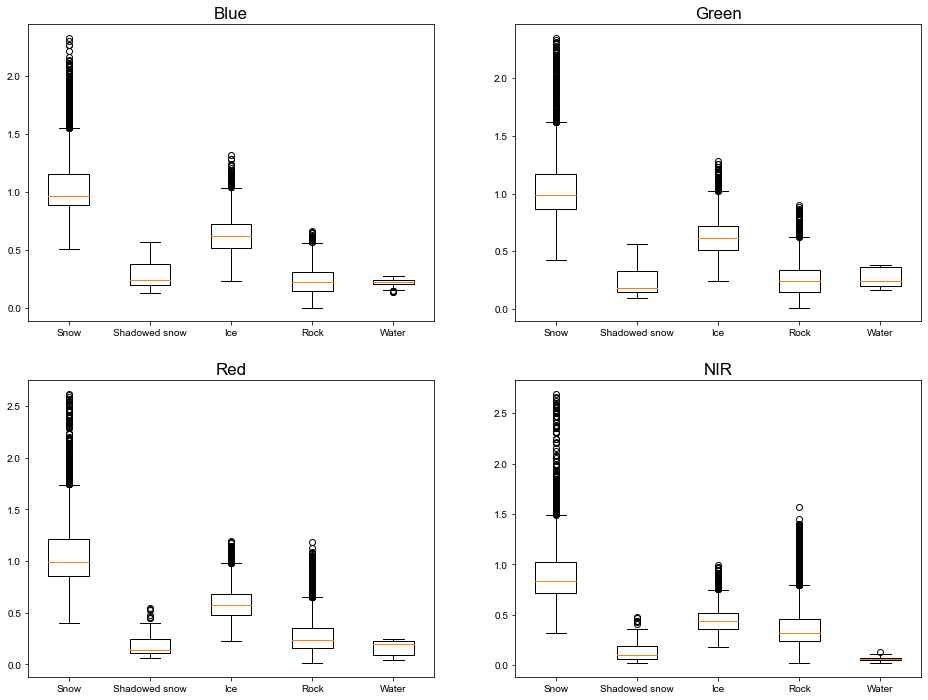

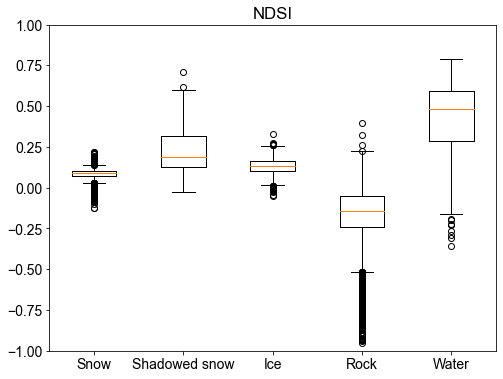

In [50]:
xticks = np.array([1, 2, 3, 4, 5], dtype=float)
xtick_labels = ['Snow', 'Shadowed snow', 'Ice', 'Rock', 'Water']
marker_size = 5
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
# blue 
data_b = [data_pts_full_PS.loc[data_pts_full_PS['class']==1]['blue'], 
          data_pts_full_PS.loc[data_pts_full_PS['class']==2]['blue'],
          data_pts_full_PS.loc[data_pts_full_PS['class']==3]['blue'],
          data_pts_full_PS.loc[data_pts_full_PS['class']==4]['blue'], 
          data_pts_full_PS.loc[data_pts_full_PS['class']==5]['blue']]
ax1.boxplot(data_b)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xtick_labels)
ax1.set_title('Blue')
# green
data_g = [data_pts_full_PS.loc[data_pts_full_PS['class']==1]['green'], 
          data_pts_full_PS.loc[data_pts_full_PS['class']==2]['green'],
          data_pts_full_PS.loc[data_pts_full_PS['class']==3]['green'],
          data_pts_full_PS.loc[data_pts_full_PS['class']==4]['green'], 
          data_pts_full_PS.loc[data_pts_full_PS['class']==5]['green']]
ax2.boxplot(data_g)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xtick_labels)
ax2.set_title('Green')
# red
data_r = [data_pts_full_PS.loc[data_pts_full_PS['class']==1]['red'], 
          data_pts_full_PS.loc[data_pts_full_PS['class']==2]['red'],
          data_pts_full_PS.loc[data_pts_full_PS['class']==3]['red'],
          data_pts_full_PS.loc[data_pts_full_PS['class']==4]['red'],
          data_pts_full_PS.loc[data_pts_full_PS['class']==5]['red']]
ax3.boxplot(data_r)
ax3.set_xticks(xticks)
ax3.set_xticklabels(xtick_labels)
ax3.set_title('Red')
# NIR
data_nir = [data_pts_full_PS.loc[data_pts_full_PS['class']==1]['NIR'], 
            data_pts_full_PS.loc[data_pts_full_PS['class']==2]['NIR'],
            data_pts_full_PS.loc[data_pts_full_PS['class']==3]['NIR'],
            data_pts_full_PS.loc[data_pts_full_PS['class']==4]['NIR'],
            data_pts_full_PS.loc[data_pts_full_PS['class']==5]['NIR']]
ax4.boxplot(data_nir)
ax4.set_xticks(xticks)
ax4.set_xticklabels(xtick_labels)
ax4.set_title('NIR')

fig2, ax = plt.subplots(1, 1, figsize=(8, 6))
# NDSI
data_ndsi = [data_pts_full_PS.loc[data_pts_full_PS['class']==1]['NDSI'], 
             data_pts_full_PS.loc[data_pts_full_PS['class']==2]['NDSI'],
             data_pts_full_PS.loc[data_pts_full_PS['class']==3]['NDSI'],
             data_pts_full_PS.loc[data_pts_full_PS['class']==4]['NDSI'], 
             data_pts_full_PS.loc[data_pts_full_PS['class']==5]['NDSI']]
ax.boxplot(data_ndsi)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_ylim(-1, 1)
ax.set_title('NDSI')
plt.show()

# -----Plot terrain parameters of each class
if terrain_parameters==True:
    xticks = np.array([1, 2, 3, 4, 5], dtype=float)
    xtick_labels = ['Snow', 'Shadowed snow', 'Ice', 'Rock', 'Water']
    marker_size = 5
    fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
    plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
    # elevation 
    data_elev = [data_pts_full_PS.loc[data_pts_full_PS['class']==1]['elevation'], 
              data_pts_full_PS.loc[data_pts_full_PS['class']==2]['elevation'],
              data_pts_full_PS.loc[data_pts_full_PS['class']==3]['elevation'],
              data_pts_full_PS.loc[data_pts_full_PS['class']==4]['elevation'], 
              data_pts_full_PS.loc[data_pts_full_PS['class']==5]['elevation']]
    ax1.boxplot(data_elev)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xtick_labels)
    ax1.set_title('Elevation')
    # slope
    data_slope = [data_pts_full_PS.loc[data_pts_full_PS['class']==1]['slope'], 
              data_pts_full_PS.loc[data_pts_full_PS['class']==2]['slope'],
              data_pts_full_PS.loc[data_pts_full_PS['class']==3]['slope'],
              data_pts_full_PS.loc[data_pts_full_PS['class']==4]['slope'], 
              data_pts_full_PS.loc[data_pts_full_PS['class']==5]['slope']]
    ax2.boxplot(data_slope)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xtick_labels)
    ax2.set_title('slope')
    # aspect
    data_aspect = [data_pts_full_PS.loc[data_pts_full_PS['class']==1]['aspect'], 
              data_pts_full_PS.loc[data_pts_full_PS['class']==2]['aspect'],
              data_pts_full_PS.loc[data_pts_full_PS['class']==3]['aspect'],
              data_pts_full_PS.loc[data_pts_full_PS['class']==4]['aspect'],
              data_pts_full_PS.loc[data_pts_full_PS['class']==5]['aspect']]
    ax3.boxplot(data_aspect)
    ax3.set_xticks(xticks)
    ax3.set_xticklabels(xtick_labels)
    ax3.set_title('aspect')

    plt.show()

## 2. Landsat

### Set-up training data

In [ ]:
# -----Define bands and feature columns (predictors used in classification)
# Landsat 8 bands: 
# SR_B2=Blue, SR_B3=Green, SR_B4=Red, SR_B5=NIR, SR_B6=SWIR1, SR_B7=SWIR2
band_names = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
feature_cols_L = band_names + ['NDSI']
# buffer used for clipping images
buffer = [1000, 3000, 1000, 3000] # [m]

# -----Check if training data exist in file
L_training_data_fn = 'L_training_data.pkl'
if os.path.exists(out_path + L_training_data_fn):
    
    data_pts_full_L = pd.read_pickle(out_path + L_training_data_fn)
    print('Landsat training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_L = data_pts_full_PS.copy(deep=True)
    data_pts_full_L = data_pts_full_L.drop(columns=['blue', 'red', 'green', 'NIR', 'NDSI'])
    data_pts_full_L[band_names] = " " # initialize band columns

    # Loop through sites
    for i in range(len(site_names)):
    
        print('----------')
        print(site_names[i])
        print('----------')

        # Extract image dates from data point file names
        im_dates = [s[len(site_names[i])+1:len(site_names[i])+9] for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s)]

        # Load AOI
        AOI_fn = site_names[i] + '_RGI.shp'
        AOI = gpd.read_file(AOI_path+AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs(4326)
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_names[i]=='Gulkana':
            im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067016_20210610'
            im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_068016_20210804'
        elif site_names[i]=='SCascade':
            im1_fn= 'LANDSAT/LC08/C02/T1_L2/LC08_046026_20210709'
            im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_045026_20210819'
        elif site_names[i]=='Sperry':
            im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_041026_20210706'
            im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_041026_20210722'
        elif site_names[i]=='Wolverine':
            im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067018_20220629'
            im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067018_20210829'
        im1, im2 = ee.Image(im1_fn), ee.Image(im2_fn)
    
        # Clip images and select bands
        im1_clip = im1.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names)
        im2_clip = im2.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names)
        
        # Determine optimal UTM zone EPSG code
        epsg_code = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])
        
        # Convert images to xarray Datasets
        im1_xr = im1_clip.wx.to_xarray(scale=20, crs='EPSG:'+epsg_code)
        im2_xr = im2_clip.wx.to_xarray(scale=20, crs='EPSG:'+epsg_code)
        
        # Create list of images
        im_list = [im1_xr, im2_xr]
        
        # Loop through image dates
        for j in np.arange(0,len(im_dates)):

            # select df columns for study site and image date
            data_pts = data_pts_full_L.loc[(data_pts_full_L['site_name']==site_names[i]) 
                                            & (data_pts_full_L['PS_im_date']==im_dates[j][0:4]+'-'+im_dates[j][4:6]+'-'+im_dates[j][6:8])]
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_code)
            # grab x and y coordinates for data points at the site
            data_pts_x = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].x
                          for i in np.arange(0,len(data_pts))]
            data_pts_y = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].y
                          for i in np.arange(0,len(data_pts))]

            # plot images and data points
            im_scalar = 0.0000275
            fig1, ax1 = plt.subplots(1, 1, figsize=(6,6))
            ax1.imshow(np.dstack([im_list[j]['SR_B4'].data[0]*im_scalar, im_list[j]['SR_B3'].data[0]*im_scalar, im_list[j]['SR_B2'].data[0]*im_scalar]),
                      extent=(np.min(im_list[j].x.data)/1000, np.max(im_list[j].x.data)/1000, 
                              np.min(im_list[j].y.data)/1000, np.max(im_list[j].y.data)/1000))
            ax1.scatter([x.geoms[0].x/1000 for x in data_pts['geometry'].loc[data_pts['class']==1]], 
                        [x.geoms[0].y/1000 for x in data_pts['geometry'].loc[data_pts['class']==1]], c='cyan', s=2)
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            plt.show()
        
            # extract band values at data points 
            band_scalar = 10000 # scalar multiplier applied to surface reflectance values
            samples = im_list[j].sel(x=data_pts_x, y=data_pts_y, method="nearest", tolerance=10)
            for band_name in band_names:
                band = samples[band_name].data # numpy array of band at points
                data_pts[band_name] = band[0][0] #/ band_scalar

            # add data_pts back to full df
            data_pts_full_L.loc[(data_pts_full_L['site_name']==site_names[i]) 
                                 & (data_pts_full_L['PS_im_date']==im_dates[j][0:4]+'-'+im_dates[j][4:6]+'-'+im_dates[j][6:8])] = data_pts

    # Remove no data points
    data_pts_full_L = data_pts_full_L.dropna().reset_index(drop=True)
    
    # Add NDSI column (G-SWIR)/(G+SWIR)
    data_pts_full_L['NDSI'] = ((data_pts_full_L['SR_B3'] -  data_pts_full_L['SR_B6'])
                                /(data_pts_full_L['SR_B3'] +  data_pts_full_L['SR_B6']))
    
    # Reduce memory usage in df
    data_pts_full_L = f.reduce_memory_usage(data_pts_full_L)
    
    # Save training data to file
    data_pts_full_L.to_pickle(out_path + L_training_data_fn)
    print('Landsat training data saved to file:' + out_path + L_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'L_feature_cols.pkl'
    pickle.dump(feature_cols_L, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)

### Test one classifier for _each_ site

In [ ]:
# -----Test supervised classification algorithms
# Loop through sites
for i in range(len(site_names)):
    
    print('----------')
    print(site_names[i])
    print('----------')
 
    # Select all columns in data_pts_full_PS for site
    data_pts = data_pts_full_L.loc[data_pts_full_L['site_name']==site_names[i]]
    data_pts = data_pts.reset_index(drop=True)
    
    # Split data points into features (band values / terrain parameters) and target variable (class)
    X = data_pts[feature_cols_L] # features
    y = data_pts['class'] # target variable
    
    # Iterate over classifiers
    accuracy = np.zeros(len(classifiers)) # mean accuracy
    K = np.zeros(len(classifiers)) # mean Kappa score
    j=0
    for name, clf in zip(names, classifiers):
    
        # Conduct K-Fold cross-validation
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
        accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
        K_folds = np.zeros(num_folds) # kappa score for all MC simulations
        k=0 # iteration counter
        # enumerate the splits and summarize the distributions
        for train_ix, test_ix in kfold.split(X):
            
            # select rows
            X_train, X_test = X.loc[train_ix], X.loc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            
            # Train classifier
            clf.fit(X_train, y_train)

            # Predict class values using trained classifier
            y_pred = clf.predict(X_test)

            # Calculate overall accuracy
            accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
            # Calculate Kappa score
            K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
            
            k+=1
        
        # Calculate mean accuracy and Kappa score
        accuracy[j] = np.nanmean(accuracy_folds)
        K[j] = np.nanmean(K_folds)
        
        j+=1

    # Determine best classifier based on accuracy
    results = pd.DataFrame()
    results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
    clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
    clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
    print(results)
    print('')
    print('Best accuracy classifier: ' + clf_best_name)

    # -----Save most accurate classifier
    if save_outputs==True:
        clf_fn = out_path + 'L_classifier_'+site_names[i]+'.sav'
        pickle.dump(clf_best, open(clf_fn, 'wb'))
        print('Most accurate classifier saved to file: ',clf_fn)

### Test one classifier for _all_ sites

In [ ]:
# -----Test supervised classification algorithms
data_pts_full_L = data_pts_full_L.reset_index(drop=True)
X = data_pts_full_L[feature_cols_L] # features
y = data_pts_full_L['class'] # target variable
    
# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # Conduct K-Fold cross-validation
    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)

        k+=1
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
#     results['TP'], results['TN'], results['FP'], results['FN'] = TP, TN, FP, FN
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path+'L_classifier_all_sites.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)

## 3. Sentinel-2

### Set-up training data

In [ ]:
# -----Define bands and feature columns (predictors used in classification)
# Sentinel-2 bands: 
# B2=Blue, B3=Green, B4=Red, B5=Red Edge 1, B6=Red Edge 2, B7=Red Edge 3, B8=NIR, 
# B8A=Red Edge 4, B9=Water vapor, B11=SWIR1, B12=SWIR2
band_names = ['B2', 'B3', 'B4', 'B5', 'B6', 'B8', 'B11', 'B12']
feature_cols_S2 = band_names + ['NDSI']
# buffer used for clipping images
buffer = [1000, 3000, 1000, 3000] # [m]

# -----Check if training data exist in file
S2_training_data_fn = 'S2_training_data.pkl'
if os.path.exists(out_path + S2_training_data_fn):
    
    data_pts_full_S2 = pd.read_pickle(out_path + S2_training_data_fn)
    print('S2 training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_S2 = data_pts_full_PS.copy(deep=True)
    data_pts_full_S2 = data_pts_full_S2.drop(columns=['blue', 'red', 'green', 'NIR', 'NDSI'])
    data_pts_full_S2[band_names] = " " # initialize band columns

    # Loop through sites
    for i in range(len(site_names)):
    
        print('----------')
        print(site_names[i])
        print('----------')

        # Extract image dates from data point file names
        im_dates = [s[len(site_names[i])+1:len(site_names[i])+9] for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s)]

        # Load AOI
        AOI_fn = site_names[i] + '_RGI.shp'
        AOI = gpd.read_file(AOI_path+AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs(4326)
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_names[i]=='Gulkana':
            im1_fn = '20210615T211519_20210615T211514_T06VWR'
            im2_fn = '20210802T212531_20210802T212655_T06VWR'
        elif site_names[i]=='SCascade':
            im1_fn= '20210704T190921_20210704T191755_T10UFU'
            im2_fn = '20210825T185919_20210825T190431_T10UFU'
        elif site_names[i]=='Sperry':
            im1_fn = '20210630T183919_20210630T184143_T11UQP'
            im2_fn = '20210730T183919_20210730T184810_T11UQP'
        elif site_names[i]=='Wolverine':
            im1_fn = '20210615T211519_20210615T211514_T06VUN'
            im2_fn = '20210829T211521_20210829T211714_T06VUN'
        im1, im2 = ee.Image('COPERNICUS/S2_SR/'+im1_fn), ee.Image('COPERNICUS/S2_SR/'+im2_fn)
    
        # Clip images and select bands
        im1_clip = im1.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names)
        im2_clip = im2.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names)
        
        # Determine optimal UTM zone EPSG code
        epsg_code = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])
        
        # Convert images to xarray Datasets
        im1_xr = im1_clip.wx.to_xarray(scale=20, crs='EPSG:'+epsg_code)
        im2_xr = im2_clip.wx.to_xarray(scale=20, crs='EPSG:'+epsg_code)
        
        # Create list of images
        im_list = [im1_xr, im2_xr]
        
        # Loop through image dates
        for j in np.arange(0,len(im_dates)):

            # select df columns for study site and image date
            data_pts = data_pts_full_S2.loc[(data_pts_full_S2['site_name']==site_names[i]) 
                                            & (data_pts_full_S2['PS_im_date']==im_dates[j][0:4]+'-'+im_dates[j][4:6]+'-'+im_dates[j][6:8])]
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_code)
            # grab x and y coordinates for data points at the site
            data_pts_x = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].x
                          for i in np.arange(0,len(data_pts))]
            data_pts_y = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].y
                          for i in np.arange(0,len(data_pts))]

            # plot images and data points
            fig1, ax1 = plt.subplots(1, 1, figsize=(6,6))
            ax1.imshow(np.dstack([im_list[j]['B4'].data[0]/10000, im_list[j]['B3'].data[0]/10000, im_list[j]['B2'].data[0]/10000]),
                      extent=(np.min(im_list[j].x.data)/1000, np.max(im_list[j].x.data)/1000, 
                              np.min(im_list[j].y.data)/1000, np.max(im_list[j].y.data)/1000))
            ax1.scatter([x.geoms[0].x/1000 for x in data_pts['geometry'].loc[data_pts['class']==1]], 
                        [x.geoms[0].y/1000 for x in data_pts['geometry'].loc[data_pts['class']==1]], c='cyan', s=2)
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            plt.show()
        
            # extract band values at data points 
            band_scalar = 10000 # scalar multiplier applied to surface reflectance values
            samples = im_list[j].sel(x=data_pts_x, y=data_pts_y, method="nearest", tolerance=10)
            for band_name in band_names:
                band = samples[band_name].data # numpy array of band at points
                data_pts[band_name] = band[0][0] #/ band_scalar

            # add data_pts back to full df
            data_pts_full_S2.loc[(data_pts_full_S2['site_name']==site_names[i]) 
                                 & (data_pts_full_S2['PS_im_date']==im_dates[j][0:4]+'-'+im_dates[j][4:6]+'-'+im_dates[j][6:8])] = data_pts

    # Remove no data points
    data_pts_full_S2 = data_pts_full_S2.dropna().reset_index(drop=True)
    
    # Add NDSI column (G-SWIR)/(G+SWIR)
    data_pts_full_S2['NDSI'] = ((data_pts_full_S2['B3'] -  data_pts_full_S2['B11'])
                                /(data_pts_full_S2['B3'] +  data_pts_full_S2['B11']))
    
    # Reduce memory usage in df
    data_pts_full_S2 = f.reduce_memory_usage(data_pts_full_S2)
    
    # Save training data to file
    data_pts_full_S2.to_pickle(out_path + S2_training_data_fn)
    print('S2 training data saved to file:' + out_path + S2_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'S2_feature_cols.pkl'
    pickle.dump(feature_cols_S2, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)

### Test one classifier for _each_ site

In [ ]:
# Sentinel-2 bands: 
# B2=Blue, B3=Green, B4=Red, B5=Red Edge 1, B6=Red Edge 2, B7=Red Edge 3, B8=NIR, 
# B8A=Red Edge 4, B9=Water vapor, B11=SWIR1, B12=SWIR2
# feature_cols_S2 = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDSI']

# -----Test supervised classification algorithms
# Loop through sites
for i in range(len(site_names)):
    
    print('----------')
    print(site_names[i])
    print('----------')
 
    # Select all columns in data_pts_full_PS for site
    data_pts = data_pts_full_S2.loc[data_pts_full_S2['site_name']==site_names[i]]
    data_pts = data_pts.reset_index(drop=True)
    
    # Split data points into features (band values / terrain parameters) and target variable (class)
    X = data_pts[feature_cols_S2] # features
    y = data_pts['class'] # target variable
    
    # Iterate over classifiers
    accuracy = np.zeros(len(classifiers)) # mean accuracy
    K = np.zeros(len(classifiers)) # mean Kappa score
    j=0
    for name, clf in zip(names, classifiers):
    
        print(name)
        
        # Conduct K-Fold cross-validation
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
        accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
        K_folds = np.zeros(num_folds) # kappa score for all MC simulations
        k=0 # iteration counter
        # enumerate the splits and summarize the distributions
        for train_ix, test_ix in kfold.split(X):
            
            # select rows
            X_train, X_test = X.loc[train_ix], X.loc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            
            # Train classifier
            clf.fit(X_train, y_train)

            # Predict class values using trained classifier
            y_pred = clf.predict(X_test)

            # Calculate overall accuracy
            accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
            # Calculate Kappa score
            K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
            
            k+=1
        
        # Calculate mean accuracy and Kappa score
        accuracy[j] = np.nanmean(accuracy_folds)
        K[j] = np.nanmean(K_folds)
        
        j+=1

    # Determine best classifier based on accuracy
    results = pd.DataFrame()
    results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
    clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
    clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
    print(results)
    print('')
    print('Best accuracy classifier: ' + clf_best_name)

    # -----Save most accurate classifier
    if save_outputs==True:
        clf_fn = out_path + 'S2_classifier_'+site_names[i]+'.sav'
        pickle.dump(clf_best, open(clf_fn, 'wb'))
        print('Most accurate classifier saved to file: ',clf_fn)  

### Test one classifier for _all_ sites

In [ ]:
# -----Test supervised classification algorithms
data_pts_full_S2 = data_pts_full_S2.reset_index(drop=True)
X = data_pts_full_S2[feature_cols_S2] # features
y = data_pts_full_S2['class'] # target variable
    
# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # Conduct K-Fold cross-validation
    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)

        k+=1
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
#     results['TP'], results['TN'], results['FP'], results['FN'] = TP, TN, FP, FN
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path+'S2_classifier_all_sites.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)

## 4. MODIS

### Set-up training data

In [ ]:
# -----Define bands and feature columns (predictors used in classification)
# MODIS bands: 
# sur_refl_b01=Red, sur_refl_b04=Green, sur_refl_b03=Blue, sur_refl_b05=SWIR1, 
# sur_refl_b06=SWIR2, sur_refl_b07=SWIR3
band_names = ['sur_refl_'+x for x in ['b01', 'b04', 'b03', 'b05', 'b06', 'b07']]
feature_cols_M = band_names + ['NDSI']
# buffer used for clipping images
buffer = [1000, 3000, 1000, 3000] # [m]

# -----Check if training data exist in file
M_training_data_fn = 'M_training_data.pkl'
if os.path.exists(out_path + M_training_data_fn):
    
    data_pts_full_M = pd.read_pickle(out_path + M_training_data_fn)
    print('MODIS training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_M = data_pts_full_PS.copy(deep=True)
    data_pts_full_M = data_pts_full_M.drop(columns=['blue', 'red', 'green', 'NIR', 'NDSI'])
    data_pts_full_M[band_names] = " " # initialize band columns

    # Loop through sites
    for i in range(len(site_names)):
    
        print('----------')
        print(site_names[i])
        print('----------')

        # Extract image dates from data point file names
        im_dates = [s[len(site_names[i])+1:len(site_names[i])+9] for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s)]

        # Load AOI
        AOI_fn = site_names[i] + '_RGI.shp'
        AOI = gpd.read_file(AOI_path+AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs(4326)
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_names[i]=='Gulkana':
            im1_fn = '2021_06_15'
            im2_fn = '2021_08_06'
        elif site_names[i]=='SCascade':
            im1_fn= '2021_07_03'
            im2_fn = '2021_08_28'
        elif site_names[i]=='Sperry':
            im1_fn = '2021_06_27'
            im2_fn = '2021_08_01'
        elif site_names[i]=='Wolverine':
            im1_fn = '2021_06_15'
            im2_fn = '2021_08_15'
        im1, im2 = ee.Image('MODIS/061/MOD09GA/'+im1_fn), ee.Image('MODIS/061/MOD09GA/'+im2_fn)
    
        # Clip images and select bands
        im1_clip = im1.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names)
        im2_clip = im2.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names)
        
        # Determine optimal UTM zone EPSG code
        epsg_code = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])
        
        # Convert images to xarray Datasets
        im1_xr = im1_clip.wx.to_xarray(scale=20, crs='EPSG:'+epsg_code)
        im2_xr = im2_clip.wx.to_xarray(scale=20, crs='EPSG:'+epsg_code)
        
        # Create list of images
        im_list = [im1_xr, im2_xr]
        
        # Loop through image dates
        for j in np.arange(0,len(im_dates)):

            # select df columns for study site and image date
            data_pts = data_pts_full_M.loc[(data_pts_full_M['site_name']==site_names[i]) 
                                            & (data_pts_full_M['PS_im_date']==im_dates[j][0:4]+'-'+im_dates[j][4:6]+'-'+im_dates[j][6:8])]
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_code)
            # grab x and y coordinates for data points at the site
            data_pts_x = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].x
                          for i in np.arange(0,len(data_pts))]
            data_pts_y = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].y
                          for i in np.arange(0,len(data_pts))]

            # plot images and data points
            fig1, ax1 = plt.subplots(1, 1, figsize=(6,6))
            ax1.imshow(np.dstack([im_list[j]['sur_refl_b01'].data[0]/10000, im_list[j]['sur_refl_b04'].data[0]/10000, im_list[j]['sur_refl_b03'].data[0]/10000]),
                      extent=(np.min(im_list[j].x.data)/1000, np.max(im_list[j].x.data)/1000, 
                              np.min(im_list[j].y.data)/1000, np.max(im_list[j].y.data)/1000))
            ax1.scatter([x.geoms[0].x/1000 for x in data_pts['geometry'].loc[data_pts['class']==1]], 
                        [x.geoms[0].y/1000 for x in data_pts['geometry'].loc[data_pts['class']==1]], c='cyan', s=2)
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            plt.show()
        
            # extract band values at data points 
            band_scalar = 10000 # scalar multiplier applied to surface reflectance values
            samples = im_list[j].sel(x=data_pts_x, y=data_pts_y, method="nearest", tolerance=10)
            for band_name in band_names:
                band = samples[band_name].data # numpy array of band at points
                data_pts[band_name] = band[0][0] #/ band_scalar

            # add data_pts back to full df
            data_pts_full_M.loc[(data_pts_full_M['site_name']==site_names[i]) 
                                 & (data_pts_full_M['PS_im_date']==im_dates[j][0:4]+'-'+im_dates[j][4:6]+'-'+im_dates[j][6:8])] = data_pts

    # Remove no data points
    data_pts_full_M = data_pts_full_M.dropna().reset_index(drop=True)
    
    # Add NDSI column (G-SWIR)/(G+SWIR)
    data_pts_full_M['NDSI'] = ((data_pts_full_M['sur_refl_b04'] -  data_pts_full_M['sur_refl_b06'])
                                /(data_pts_full_M['sur_refl_b04'] +  data_pts_full_M['sur_refl_b06']))
    
    # Reduce memory usage in df
    data_pts_full_M = f.reduce_memory_usage(data_pts_full_M)
    
    # Save training data to file
    data_pts_full_M.to_pickle(out_path + M_training_data_fn)
    print('MODIS training data saved to file:' + out_path + M_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'M_feature_cols.pkl'
    pickle.dump(feature_cols_M, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)  

### Test one classifier for _each_ site

In [ ]:
# -----Test supervised classification algorithms
# Loop through sites
for i in range(len(site_names)):
    
    print('----------')
    print(site_names[i])
    print('----------')
 
    # Select all columns in data_pts_full_PS for site
    data_pts = data_pts_full_M.loc[data_pts_full_M['site_name']==site_names[i]]
    data_pts = data_pts.reset_index(drop=True)
    
    # Split data points into features (band values / terrain parameters) and target variable (class)
    X = data_pts[feature_cols_M] # features
    y = data_pts['class'] # target variable
    
    # Iterate over classifiers
    accuracy = np.zeros(len(classifiers)) # mean accuracy
    K = np.zeros(len(classifiers)) # mean Kappa score
    j=0
    for name, clf in zip(names, classifiers):
    
        print(name)
        
        # Conduct K-Fold cross-validation
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
        accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
        K_folds = np.zeros(num_folds) # kappa score for all MC simulations
        k=0 # iteration counter
        # enumerate the splits and summarize the distributions
        for train_ix, test_ix in kfold.split(X):
            
            # select rows
            X_train, X_test = X.loc[train_ix], X.loc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            
            # Train classifier
            clf.fit(X_train, y_train)

            # Predict class values using trained classifier
            y_pred = clf.predict(X_test)

            # Calculate overall accuracy
            accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
            # Calculate Kappa score
            K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
            
            k+=1
        
        # Calculate mean accuracy and Kappa score
        accuracy[j] = np.nanmean(accuracy_folds)
        K[j] = np.nanmean(K_folds)
        
        j+=1

    # Determine best classifier based on accuracy
    results = pd.DataFrame()
    results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
    clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
    clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
    print(results)
    print('')
    print('Best accuracy classifier: ' + clf_best_name)

    # -----Save most accurate classifier
    if save_outputs==True:
        clf_fn = out_path + 'M_classifier_'+site_names[i]+'.sav'
        pickle.dump(clf_best, open(clf_fn, 'wb'))
        print('Most accurate classifier saved to file: ',clf_fn)   

### Test one classifier for _all_ sites

In [ ]:
# -----Test supervised classification algorithms
X = data_pts_full_M[feature_cols_M].reset_index(drop=True) # features
y = data_pts_full_M['class'].reset_index(drop=True) # target variable
    
# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # Conduct K-Fold cross-validation
    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)

        k+=1
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
#     results['TP'], results['TN'], results['FP'], results['FN'] = TP, TN, FP, FN
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path+'M_classifier_all_sites.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)